## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
checkpoint_path = "outdir/checkpoint_78000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [5]:
ref_mel = get_mel('test/test0.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

torch.float16 torch.Size([1, 80, 687])


In [62]:

# text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не мож+ет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
# text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Svs+e smesh+alos' v d+ome obl+onskikh. zhen+a uzn+ala, chto muzh byl v sv+iazi s b+yvsheiu v ikh d+ome frants+uzhenkoiu-guvern+antkoi, i ob'iav+ila m+uzhu, chto ne mozhet zh+it' s nim v odn+om d+ome. polozh+enie eto prodolzh+alos' uzhe tretii d+en' i much+itel'no ch+uvstvovalos' i sam+imi supr+ugami, i vs+emi chl+enami sem'+i, i domoch+adtsami.E
[[12 35 32 40 18 11 32 26 18 32 21 40 14 25 28 32  3 11 35 11 17 40 28 26
  18 11 28 15 25 40 28 27 32 24 22 24 21  7 11 39 21 18 27 40 14 11 34 39
  27 40 14 25 14  6 11 16 21 33 28 11 26 34 39 21 11 15 38 25 11 35 11 32
  35 40 22 14 39 22 11 32 11 15 40 38 35 32 21 18 22 34 11 35 11 22 24 21
  11 17 40 28 26 18 11 19 31 14 27 33 32 40 34 39 21 18 27 24 28 22 34  1
  20 34 35 18 31 27 40 14 27 33 24 28 22  6 11 22 11 28 15  3 22 14 35 40
  22 25 14 11 26 40 34 39 21 34  6 11 16 21 33 28 11 27 18 11 26 28 39 21
  18 33 11 39 21 40 22 33  3 11 32 11 27 22 26 11 35 11 28 17 27 40 28 26
  11 17 40 28 26 18  7 11 29 28 25 28 39 21 40 18 27 22 18 1

In [63]:
%%time
# np.random.seed(16)

_, mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence,seed=None)

CPU times: user 1.67 s, sys: 31.4 ms, total: 1.7 s
Wall time: 1.71 s


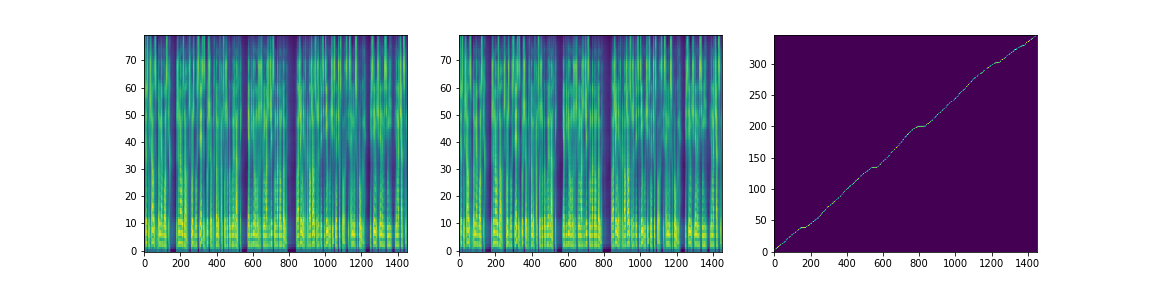

In [64]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [68]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

device = torch.device('cuda')
with open('hifigan/config.json') as fp:
    json_config = json.load(fp)
    h = AttrDict(json_config)
generator = Generator(h).to(device)

state_dict_g = load_checkpoint("hifigan/g_02500000", device)
generator.load_state_dict(state_dict_g['generator'])

def inference(mel, generator):
    

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    
mel = mel_outputs_postnet.type(torch.float32)
%%time
audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)

Loading 'hifigan/g_02500000'
Complete.


UsageError: Line magic function `%%time` not found.
